# Separation of CIFAR-10 Images

### Andrea Bedei

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

## Libraries

In [16]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Image

## Dataset loading

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

## Dataset splitting
The dataset was divided into subsets for training, validation, and testing, with specific attention given to separating classes. First, the training set was split into two parts: one containing images of the first five classes (class < 5) and the other containing images of the remaining classes (class >= 5). For both parts, 20% of the data was allocated as a validation set. This ensures proper validation without using the test set during the training process, which is critical for avoiding data leakage and maintaining the integrity of the evaluation process. Similarly, the test set was split into two parts, following the same class separation criteria, to maintain consistency in the dataset structure.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]
train_x_1, val_x_1, train_y_1, val_y_1 = train_test_split(
    cifar10_x_train_1, cifar10_y_train_1, test_size=0.2, random_state=47
)

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]
train_x_2, val_x_2, train_y_2, val_y_2 = train_test_split(
    cifar10_x_train_2, cifar10_y_train_2, test_size=0.2, random_state=47
)

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [4]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [5]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: airplane, second = ship


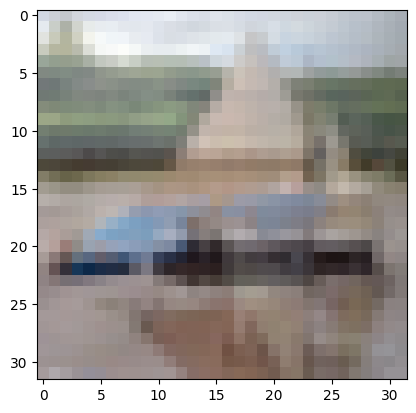

In [6]:
x, y = next(datagen)
print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [7]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


## Select the right model
In this project, two main approaches were considered for the task. Here, the first approach is described in detail as it yielded better result. The second approach will be outlined at the end of the notebook.

The task involved predicting two separate classifications, each consisting of 5 classes. To address this, the model required two output heads, one for each clasification task. The last layer of each head was designed with 5 output neurons and used the softmax activation function, as it is the standard choice for multi-class classification problems.

### Model Design
This approach utilized a deep cnn, incrementally built to optimize performance and accuracy. The network struture includes:

- **Convolutional Blocks:** For feature extraction from images.
- **RelU Activation Function:** Relu was chosen for its computational efficiency and ability to mitigate the vanishing gradient problem during training.
- **Batch Normalization:** Used to stabilize and accelerate the training process by normalizing layer inputs.
- **MaxPooling2D:** Employed to reduce the spatial dimensions of feature maps, therefore lowering computational complexity and accentuate dominant features.
- **Dropout:** Regularization technique to prevent overfitting by randomly deactivating neurons during training.

All elements that we have seen during the course.

#### Residual Connections
Residual connections were incorporated in some blocks. These allow the network to learn identity mappings, making it easier to train deeper models by addressing the vanishing gradient issue. By adding the input of a layer to its output this permit to the network of maintain performance with additional depth.

#### Incremental Design
The network was gradually built and tested, starting with smaller architectures to assess the performance-to-parameter trade-off:
- **First Network of 756.000 parameters:** Achieved a mean accuracy of 80%.
- **Second Network 5.000.000 parameters:** Improved accuracy but with increased computational demands.
- **Final Network 10.000.000 parameters:** Is a balance between performance and efficiency, yielding the best results overall.

#### Architecture Details
The initial part of the network, common to both classification heads, consists of five convolutional blocks:
- **First Block:** 64 filters, followed by BatchNormalization, MaxPooling, and Dropout of 30%.
- **Second Block:** 128 filters with similar operations and 40% dropout.
- **Third and Fourth Blocks:** Include residual connections to ensure efficient training with 256 and 512 filters, respectively.
- **Fifth Block:** Concludes with 512 filters and GlobalAveragePooling2D for dimensionality reduction.

Instead, each head processes the shared features independently:
- Fully connected layers with 512 and 256 neurons, both using ReLU activation.
- Dropout layers for regularization.
- A final Dense layer with 5 neurons and softmax activation for classification.

### Final Model
The final model, with 10 million parameters, has techniques such as residual connections, dropout regularization, and BatchNormalization, achieving optimal performance for this task. The dual-head structure ensures that the network can handle the dual-classification task effectively.

In [8]:
def last_model():
    shared_input = layers.Input(shape=(32, 32, 3))
    
    shared = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(shared_input)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.MaxPooling2D((2, 2))(shared)
    shared = layers.Dropout(0.3)(shared)

    shared = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.MaxPooling2D((2, 2))(shared)
    shared = layers.Dropout(0.4)(shared)

    residual = layers.Conv2D(256, (1, 1), padding="same")(shared)
    shared = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Add()([shared, residual])
    shared = layers.MaxPooling2D((2, 2))(shared)
    shared = layers.Dropout(0.4)(shared)

    residual2 = layers.Conv2D(512, (1, 1), padding="same")(shared)
    shared = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Add()([shared, residual2])
    shared = layers.MaxPooling2D((2, 2))(shared)
    shared = layers.Dropout(0.5)(shared)

    shared = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.GlobalAveragePooling2D()(shared)

    head_A = layers.Dense(512, activation="relu")(shared)
    head_A = layers.Dropout(0.5)(head_A)
    head_A = layers.Dense(256, activation="relu")(head_A)
    head_A = layers.Dropout(0.5)(head_A)
    head_A = layers.Dense(5, activation="softmax", name="head_A")(head_A)

    head_B = layers.Dense(512, activation="relu")(shared)
    head_B = layers.Dropout(0.5)(head_B)
    head_B = layers.Dense(256, activation="relu")(head_B)
    head_B = layers.Dropout(0.5)(head_B)
    head_B = layers.Dense(5, activation="softmax", name="head_B")(head_B)

    model = models.Model(inputs=shared_input, outputs=[head_A, head_B])
    return model


## Model Compilation
Model Compilation
The model is instantiated and compiled with the following configurations:

### Optimizer
As we have seen in the lessons Adam optimizer was chosen for its efficiency in training deep learning models. Adaptive Learning Rates adjusts the learning rate for each parameter based on historical gradients, improving performance in non-stationary and sparse gradient scenarios.
The learning rate was set to 0.0001, a critical hyperparameter that controls the step size for weight updates during training.

### Hyperparameter Optimization with Optuna
Optuna Framework: the learning rate hyperparameter, 0.0001, was selected through Optuna, a framework for automated hyperparameter optimization.
Optuna systematically explored various combinations of hyperparameters by conducting multiple trials. During each trial, Optuna evaluated the performance of the model with different learning rates and selected the configuration that yielded the best results based on the defined objective function.
I have done this optimization in an other notebook for simplicity and cleanliness. The learning rate was tested with the following values: 

```python
learning_rate = trial.suggest_categorical(
    "learning_rate", [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005]
)
```

### Loss Function
The categorical crossentropy loss was used for both outputs, which is the standard loss function for multi-class classification problems. It measures the divergence between the predicted probability distribution and the true distribution, pushing the model to make predictions closer to the correct class.

### Metrics
Accuracy was used as the evaluation metric for both classification heads.

In [9]:
last_model = last_model()
last_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  
    loss=["categorical_crossentropy", "categorical_crossentropy"],
    metrics=[["accuracy"], ["accuracy"]]
)

### Model structure text
Now we can see the structure of the network in text format

In [10]:
last_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['batch_normalization[0][0]']

### Model structure image
As we have seen in the courese we can represent the network with a better image  


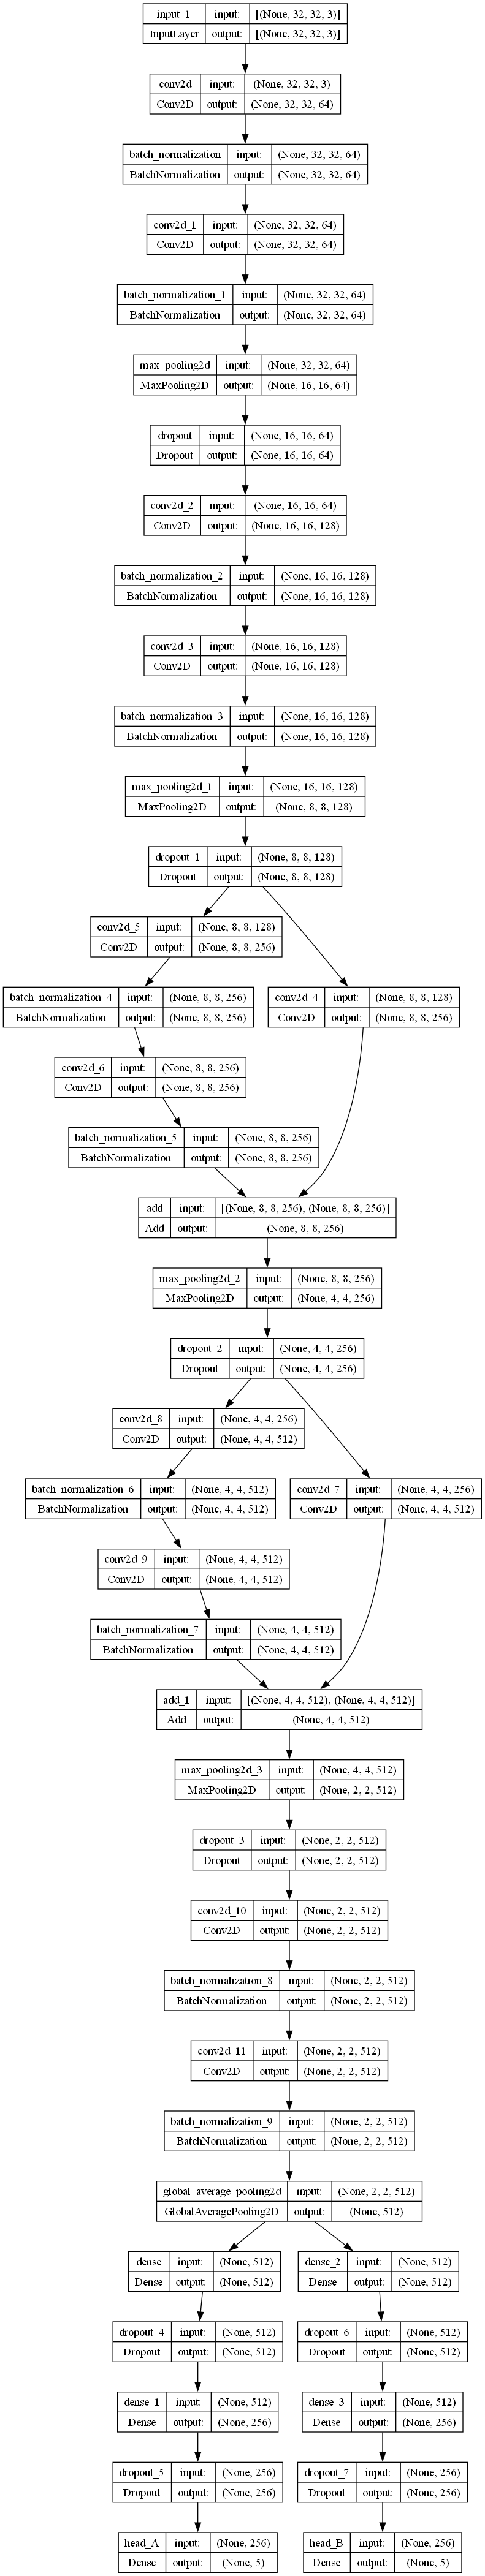

In [11]:
plot_model(
    last_model, 
    to_file='model_structure.png',  
    show_shapes=True,               
    show_layer_names=True,          
    dpi=96          
)

Image('model_structure.png')

### Data Preparation and Generator Configuration

#### Data Generators
The training and validation datasets were prepared using custom data generators:
- **train_generator:** Responsible for creating batches of mixed images for training.
- **val_generator:** Handles the creation of batches for validation.

#### Batch Size
The batch size was set to 256, which determines the number of samples the network processes in a single forward/backward pass.
This value was carefully chosen to balance between:
- **Performance:** Larger batches improve GPU utilization and reduce training time.
- **Accuracy:**  Given the large size of the dataset, this configuration represents an optimal trade-off achieved through fine-tuning.

#### Steps Per Epoch and Validation Steps
- **Steps Per Epoch:** Set to 2000, indicating that the generator produces 2000 batches of data during each epoch of training. This number was determined based on the size of the dataset and the goal of ensuring the model sees sufficient data within each epoch for effective learning.
- **Validation Steps:** Set to 200, specifying the number of validation batches used at the end of each epoch to evaluate the model's performance.

The dataset in this project is exceptionally large because every image from the first group can be paired with any image from the second group.
This combinatorial growth creates a vast number of possible data samples.
The batch size, steps per epoch, and validation steps were tuned to strike a balance between computational performance and model accuracy.
The chosen configuration ensures that the network trains efficiently without compromising the quality of learning. For this reason, the usual formula for calculating the number of steps per epoch:

$StepsPerEpoch=TrainingImages/BatchSize$ 

was not used.

In [12]:
batch_size = 256
train_generator = datagenerator(train_x_1, train_x_2, train_y_1, train_y_2, batch_size)
val_generator = datagenerator(val_x_1, val_x_2, val_y_1, val_y_2, batch_size)

steps_per_epoch = 2000  
validation_steps = 200

### Early stopping 
Early stopping is a regularization technique. It monitors the model's performance on the validation set and halts training when no significant improvement is observed for a defined number of epochs. This prevents overfitting, prolonged training can cause the model to fit the training data too closely, leading to poor generalization on unseen data. In addiction, early stopping ensures that the model retains the weights corresponding to the best validation performance.

#### Custom Implementation Details
This custom implementation of early stopping permit to:
- **Tracking Mean Accuracy:** Instead of relying on validation loss, which was initially considered, the custom callback evaluates the mean accuracy of the two output heads: `val_head_A_accuracy` e `val_head_B_accuracy`. This approach aligns with the evaluation metric, ensuring the stopping criterion focuses on the metric most relevant to model performance.
- **The mean accuracy is calculated as:** `mean_accuracy` = (`val_head_A_accuracy`+`val_head_B_accuracy`)/2
This ensures that both classification tasks are weighted equally during training.

#### Patience Parameter:
As we have seen in a laboratory the patience parameter (set to 15) defines the number of epochs the model waits before stopping if no improvement is observed. It is intentionally high to give the model enough time to navigate through potential performance plateaus. Since the data is shuffled randomly at each epoch, the model might experience fluctuations in validation performance due to chance rather than actual learning progress. A higher patience helps prevent premature stopping caused by these random variations, ensuring the model has enough epochs to converge to its optimal parameters.
This approach is particularly useful in scenarios like this, where the dataset involves a large number of mixed images, as it allows the training process to stabilize and find the best weights before stopping. However, the trade-off is a slightly longer training time before early stopping is triggered.

#### Advantages of Using Accuracy Over Loss
Accuracy directly reflects the model's performance in classification tasks, aligning with the evaluation metrics of the final results.
In multi-head models like this, the use of mean accuracy ensures that both heads are optimized simultaneously, preventing bias towards one head over the other.
Loss functions, while useful for optimization, can sometimes be misleading or less interpretable in terms of real-world performance.

In [13]:
class CustomEarlyStopping(Callback):
    def __init__(self, patience=8, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        val_head_A_accuracy = logs.get('val_head_A_accuracy', 0.0)
        val_head_B_accuracy = logs.get('val_head_B_accuracy', 0.0)

        mean_accuracy = (val_head_A_accuracy + val_head_B_accuracy) / 2.0
        logs['mean_accuracy'] = mean_accuracy

        if mean_accuracy > self.best_score:
            self.best_score = mean_accuracy
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)


custom_early_stopping = CustomEarlyStopping(
    patience=15,
    restore_best_weights=True
)

### Checkpoint_callback
This callback ensures that the model's best-performing weights are saved during training, allowing for easy restoration and evaluation later without re-training the model from scratch. It’s particularly useful in tasks where finding the optimal weights is critical to achieving the best results.

In [14]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='mean_accuracy',  
    mode='max',               
    save_best_only=True,      
    save_weights_only=True, 
    verbose=0
)

### Trains
Now we trains the model using the `fit` method, where the training data is provided by `train_generator` and validation data by `val_generator`. It specifies 200 epochs, with the number of steps per epoch set by `steps_per_epoch` and validation steps defined by `validation_steps`. During training, the model uses two callbacks: `custom_early_stopping`, which stops training early if there is no improvement in performance, and `checkpoint_callback`, which saves the best model weights based on validation accuracy. This setup ensures efficient training with real-time monitoring and model optimization.

In [15]:
history = last_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[custom_early_stopping, checkpoint_callback],
)

Epoch 1/200
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 120s 50ms/step - head_A_accuracy: 0.3810 - head_B_accuracy: 0.4244 - loss: 2.7796 - val_head_A_accuracy: 0.4180 - val_head_B_accuracy: 0.6535 - val_loss: 2.4368 - mean_accuracy: 0.5358
Epoch 2/200
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 97s 48ms/step - head_A_accuracy: 0.5632 - head_B_accuracy: 0.6726 - loss: 1.9624 - val_head_A_accuracy: 0.6050 - val_head_B_accuracy: 0.7034 - val_loss: 1.8162 - mean_accuracy: 0.6542
Epoch 3/200
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - head_A_accuracy: 0.6274 - head_B_accuracy: 0.7318 - loss: 1.6798 - val_head_A_accuracy: 0.6424 - val_head_B_accuracy: 0.7597 - val_loss: 1.5796 - mean_accuracy: 0.7010
Epoch 4/200
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - head_A_accuracy: 0.6632 - head_B_accuracy: 0.7636 - loss: 1.5203 - val_head_A_accuracy: 0.6622 - val_head_B_accuracy: 0.7653 - val_loss: 1.5423 - mean_accuracy: 0.7138
Epoch 5/200
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 96s 48ms/step - head_A_accuracy: 0.6869 - head_B

### Plot graphs
- **Left Plot:** Training and Validation Loss:
    - The blue line represents the training loss, which steadily decreases as the epochs progress, indicating that the model is learning effectively from the training data.
    - The orange line represents the validation loss, which also decreases initially but stabilizes with some oscillations. This suggests that the model generalizes well and overfitting is unlikely.

- **Right Plot:** Training and Validation Mean Accuracy:
    - The green line represents the mean training accuracy, which improves consistently and approaches 0.95 towards the final epochs.
    - The red line represents the mean validation accuracy, which increases more slowly but stabilizes around 0.83–0.85, showing good generalization to the validation data. There are oscillations, likely due to random shuffling of images in the data generation process.
### In addition
- **Overfitting:** Overfitting is unlikely in this scenario due to the enormous number of possible image combinations generated by the random shuffling. This variety ensures the model is exposed to diverse data distributions during training.
- **Oscillations:** The jagged patterns in both loss and accuracy curves are expected because the model sees different, randomly shuffled image pairs in each epoch. Some epochs might have a higher proportion of more challenging image combinations, leading to temporary drops in performance.
- **Epochs:** Training the model for fewer epochs resulted in a validation accuracy of only 0.83. Extending the training allows the model to achieve a validation accuracy of approximately 0.95, though the validation accuracy still shows slight improvements toward the end, indicating potential for further training gains.

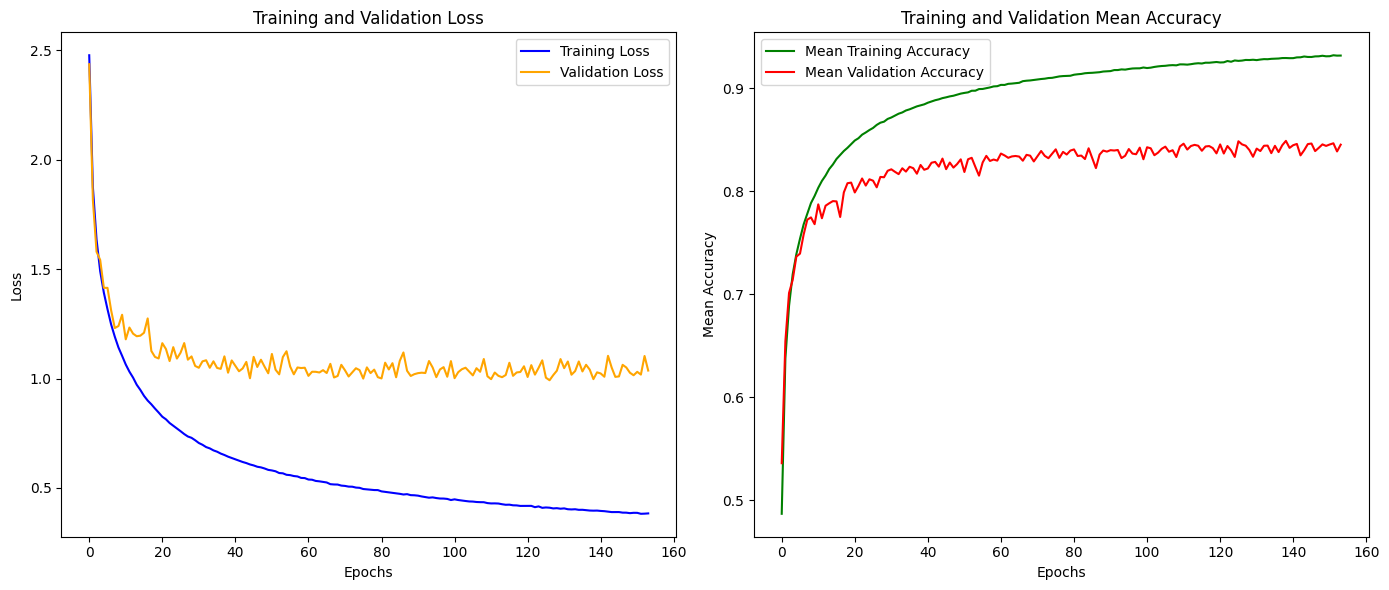

In [16]:
history_data = history.history
mean_accuracy_train = [(a + b) / 2 for a, b in zip(history_data['head_A_accuracy'], history_data['head_B_accuracy'])]
mean_accuracy_val = [(a + b) / 2 for a, b in zip(history_data['val_head_A_accuracy'], history_data['val_head_B_accuracy'])]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss', color='blue')
plt.plot(history_data['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_accuracy_train, label='Mean Training Accuracy', color='green')
plt.plot(mean_accuracy_val, label='Mean Validation Accuracy', color='red')
plt.title('Training and Validation Mean Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy for the two separate heads of the model

These plots show the training and validation accuracy for the two separate heads of the model:

- **Left Plot:** is the Head A:
    - **The blue curve:** the training accuracy, improves steadily and nears 0.92, indicating strong performance on the training set.
    - **The orange curve:** the validation accuracy, stabilizes around 0.81, with minor oscillations, showing a consistent generalization for this head.

- **Right Plot** is the Head B:
    - **The green curve:** the training accuracy, progresses smoothly, achieving near-perfect accuracy, reflecting excellent learning.
    - **The red curve:** the validation accuracy, remains slightly lower, stabilizing near 0.87, but shows fluctuations, possibly due to more challenging examples for this head.

I believe this difference in accuracy between the two heads is due to the complexity of correctly classifying the images into their respective classes. I think Head A deals with more similar class images, as i can observed when examining the division of the class in the top of the nootebook

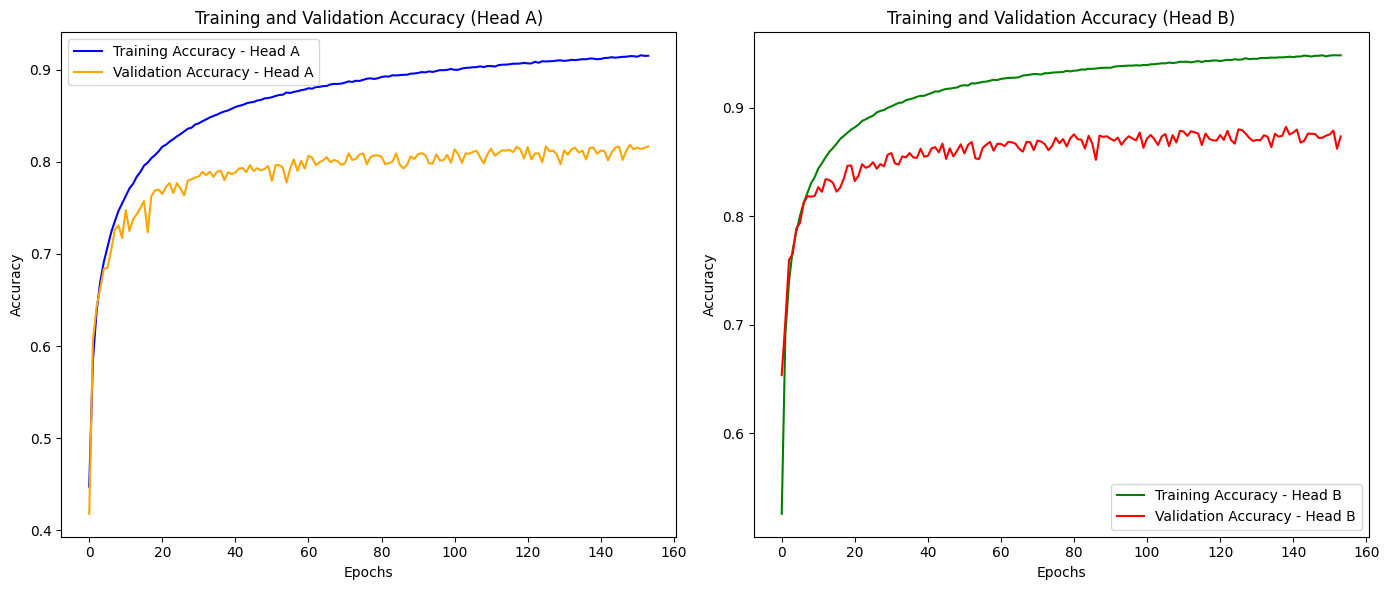

In [17]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_data['head_A_accuracy'], label='Training Accuracy - Head A', color='blue')
plt.plot(history_data['val_head_A_accuracy'], label='Validation Accuracy - Head A', color='orange')
plt.title('Training and Validation Accuracy (Head A)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data['head_B_accuracy'], label='Training Accuracy - Head B', color='green')
plt.plot(history_data['val_head_B_accuracy'], label='Validation Accuracy - Head B', color='red')
plt.title('Training and Validation Accuracy (Head B)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Model Evaluation
I have defined the evaluation of the model as in the specifics.

In [ ]:
def eval_model(model):
    eval_samples_x, eval_samples_y = next(testgen)
    guess = model.predict(eval_samples_x)

    correct_guesses_1 = np.argmax(guess[0], axis=1) == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = np.argmax(guess[1], axis=1) == np.argmax(eval_samples_y[1], axis=1)

    accuracy_1 = np.mean(correct_guesses_1)
    accuracy_2 = np.mean(correct_guesses_2)
    return (accuracy_1 + accuracy_2) / 2

### First evaluation

In [26]:
eval_model(last_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.84995

### Final evaluation
Let repeat the evaluation ten times, and compute the standard deviation

In [50]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(last_model))
print("Mean accuracy = ", np.mean(eval_results))
print("Standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean accuracy =  0.8486600000000001
Standard deviation =  0.0022232633672149716


### Conclusions
The results obtained from the training process appear to be promising, demonstrating the effectiveness of the approach taken. The use of a dual-output convolutional neural network with carefully designed shared and specialized layers allowed the model to achieve high accuracy on both classification tasks. This highlights the importance of structuring the network to address specific task requirements, such as using separate heads for the two outputs.

These results underscore the importance of a systematic approach to model design, data preparation, and training configuration. The accuracy achieved is a strong foundation, but further improvements could still be explored, such as testing alternative architectures or additional data augmentation techniques. Overall, this project demonstrates a well-balanced combination of theory and practice, achieving both strong performance and model efficiency.

## Secondo Approch


An alternative solution I considered, which yielded slightly lower accuracy compared to the chosen best approach, involves using an encoder-decoder model. The idea was to train the model to separate combined images into their constituent components. Specifically, given a mixed input image, the encoder-decoder network attempts to reconstruct the first and second images separately.

This approach required significant modifications to the overall workflow since the encoder-decoder model demands access to both original images for training. Once the images were successfully separated, they would then be classified using a ten class classifier pretrained on CIFAR 10. The final accuracy would be calculated by verifying if both reconstructed images were classified correctly.

While this method showed potential and had an interesting conceptual basis, the additional complexity introduced by separating the images and the subsequent reliance on a classifier led to slightly reduced overall performance compared to the simpler dual-output model. I believe it’s a good idea, as it explores a different perspective on solving the problem.

Below is the core part of the encoder-decoder structure and network code, which I believe represents a creative and promising direction, despite not being the final choice for this task.

In [21]:
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder with two branch
decoder_1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
decoder_1 = layers.UpSampling2D((2, 2))(decoder_1)
decoder_1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoder_1)
decoder_1 = layers.UpSampling2D((2, 2))(decoder_1)
decoder_1 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(decoder_1)

decoder_2 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
decoder_2 = layers.UpSampling2D((2, 2))(decoder_2)
decoder_2 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoder_2)
decoder_2 = layers.UpSampling2D((2, 2))(decoder_2)
decoder_2 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(decoder_2)

encoder_decoder = Model(input_img, [decoder_1, decoder_2])
encoder_decoder.compile(optimizer='adam', loss='mse')

# Other code, for training...
# Resizing form (32,32,3) to (224,224,3)
# Final Classification

classifier = tf.keras.applications.ResNet50(
    include_top=True, weights=None, classes=10, input_shape=(224, 224, 3)
)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])